In [2]:
import pandas as pd

# Datensatz erneut laden mit korrekter Kodierung
file_path = "Sample-Superstore.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
# Konvertiere das Bestelldatum in ein datetime-Format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Referenzdatum: einen Tag nach der letzten Bestellung
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)

# Berechne RFM-Werte:
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                                   # Frequency
    'Sales': 'sum'                                           # Monetary
}).reset_index()

# Spalten umbenennen
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']




In [5]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,56,6,5086.935
4,AB-10015,416,3,886.156


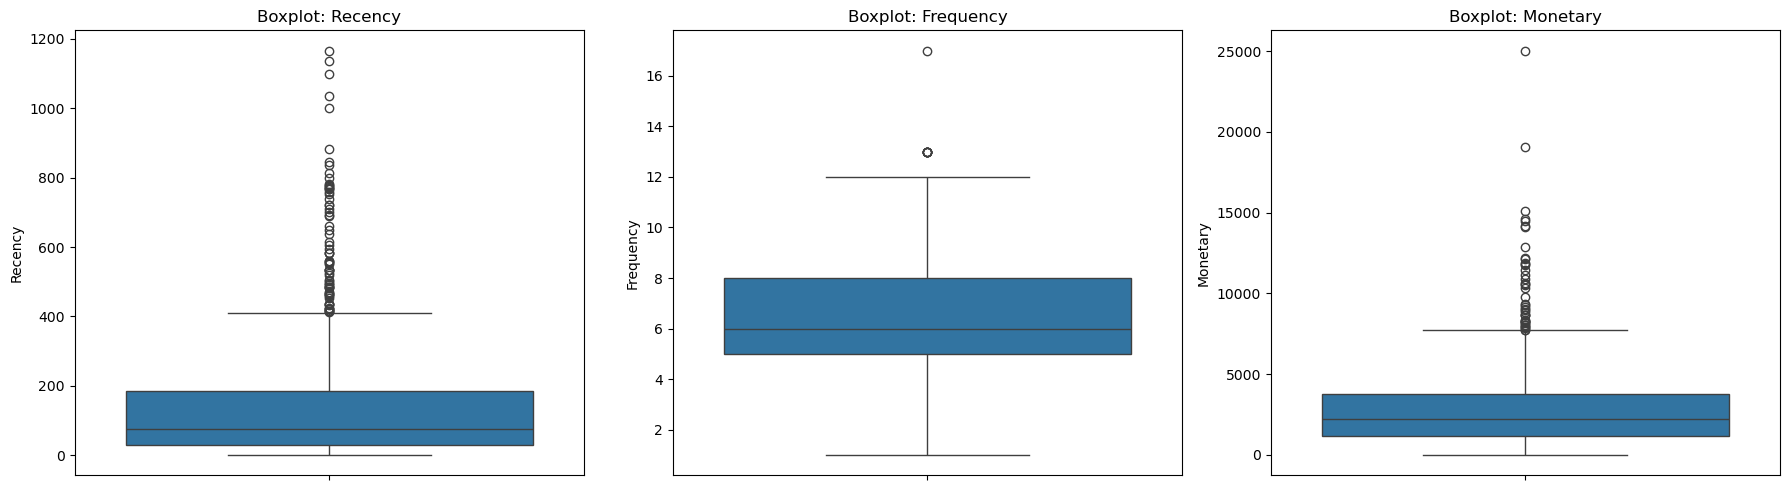

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Schritt 1: Boxplots zur Outlier-Erkennung für jede RFM-Variable
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(y=rfm['Recency'], ax=axes[0])
axes[0].set_title('Boxplot: Recency')

sns.boxplot(y=rfm['Frequency'], ax=axes[1])
axes[1].set_title('Boxplot: Frequency')

sns.boxplot(y=rfm['Monetary'], ax=axes[2])
axes[2].set_title('Boxplot: Monetary')

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# IQR-basierte Outlier-Entfernung
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Wende die Funktion auf jede RFM-Spalte an
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm = remove_outliers_iqr(rfm, col)

# Standardisierung der bereinigten Daten
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Optional: zurück in DataFrame mit Spaltennamen
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Ergebnis anzeigen
print(rfm_scaled_df.describe())


            Recency     Frequency      Monetary
count  6.740000e+02  6.740000e+02  6.740000e+02
mean  -5.007534e-17 -1.449549e-16 -3.162653e-17
std    1.000743e+00  1.000743e+00  1.000743e+00
min   -1.003017e+00 -2.344253e+00 -1.466933e+00
25%   -7.172628e-01 -6.155587e-01 -7.763449e-01
50%   -3.804809e-01 -1.833852e-01 -1.789283e-01
75%    2.803261e-01  6.809618e-01  5.406335e-01
max    3.181243e+00  2.409656e+00  2.992654e+00


In [ ]:
#Elbow-Methode (Inertia)
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)


In [10]:
#Silhouette-Methode
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):  # Silhouette nicht sinnvoll bei k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, labels)
    silhouette_scores.append(score)


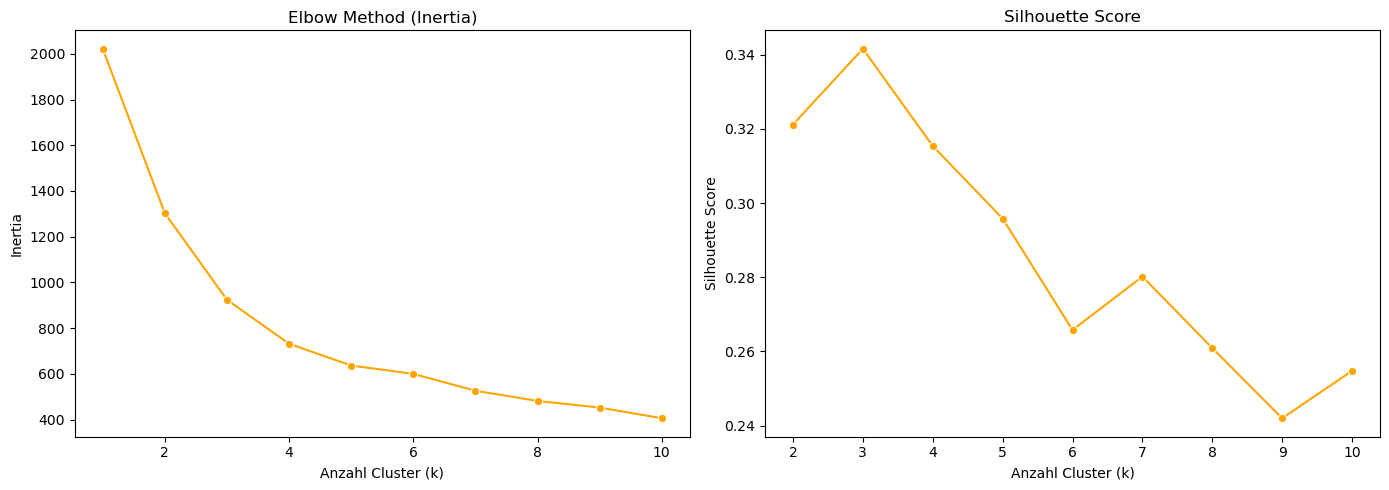

In [12]:
# Sicherstellen, dass beide Listen die gleiche Länge für die Visualisierung haben
# Silhouette hat None bei k=1, daher schneiden wir es für den Plot ab

# Neu berechnen, um sicherzugehen
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette_scores = []
K_range = list(range(1, 11))

for k in K_range:
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

    if k > 1:
        silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# Visualisierung (saubere Achsenlängen)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow-Methode (k=1 bis 10)
sns.lineplot(x=K_range, y=inertia, marker='o', color="orange", ax=ax[0])
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("Anzahl Cluster (k)")
ax[0].set_ylabel("Inertia")

# Silhouette Score (k=2 bis 10)
sns.lineplot(x=K_range[1:], y=silhouette_scores, marker='o', color="orange", ax=ax[1])
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Anzahl Cluster (k)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()
